<p align="center">
<img src='../../img/VerticaMLPython.png' width="180px">
</p>

# Vertica ML Python Exercise 8

During this exercice, we will:
<ul>
    <li> Compute frequencies
    <li> Use moving windows
    <li> Extract information on timestamps
    <li> Compute a cumulative sum
</ul>
## Initialization

Let's create a cursor using the vertica_cursor function.

In [1]:
from vertica_ml_python.utilities import vertica_cursor
cur = vertica_cursor("VerticaDSN")

During this study, we will work with a new dataset which is composed of all the US flights in 2015. 

In [2]:
from vertica_ml_python.utilities import drop_table
drop_table("flights", cur)
from vertica_ml_python.utilities import read_csv
flights = read_csv("flights/flights.csv", cur, parse_n_lines = 1000)

The table flights was successfully dropped.
The table public.flights has been successfully created.


We have access to different information like:
<ul>
    <li><b>scheduled_departure:</b> The flight scheduled departure</li>
    <li><b>origin_airport:</b> The origin airport</li>
    <li><b>destination_airport:</b> The destination airport</li>
    <li><b>airline:</b> The airline</li>
    <li><b>departure_delay:</b> The departure delay</li>
    <li><b>arrival_delay:</b> The arrival delay</li>
</ul>
The main purpose is to find which flights are more subject to delays.

In [3]:
print(flights)

,destination_airport,scheduled_departure,departure_delay,arrival_delay,origin_airport,airline
0,ABE,2015-02-05 20:10:00,0,-18,DTW,EV
1,ABE,2015-02-05 20:34:00,-1,2,ATL,DL
2,ABE,2015-02-06 10:01:00,16,7,DTW,EV
3,ABE,2015-02-06 10:31:00,58,57,ATL,EV
4,ABE,2015-02-06 13:45:00,-6,3,ATL,EV
,...,...,...,...,...,...


<object>  Name: flights, Number of rows: 4068736, Number of columns: 6


## Time Series

Let's explore the data by displaying descriptive statistics of all the columns.

In [4]:
flights.describe(method = "categorical")

,dtype,unique,count,top,top_percent
"""destination_airport""",varchar(20),629,4068736,ATL,5.46
"""scheduled_departure""",timestamp,286101,4068736,2015-04-06 13:45:00,0.003
"""departure_delay""",int,1108,4068736,-3,7.178
"""arrival_delay""",int,1135,4068736,-8,2.926
"""origin_airport""",varchar(20),621,4068736,ATL,6.744
"""airline""",varchar(20),14,4068736,WN,21.818


<object>

<b>Question 1: </b>Find the average number of flights (departure) per day and per month in the US (You should probably create new features: day/month)

In [5]:
flights["scheduled_departure"].add_copy("day").date_part("day")
flights["scheduled_departure"].add_copy("month").date_part("month")
print("avg_nb_flights_day = {}".format(flights.groupby(columns = ["day", "month"], expr = ["COUNT(*) AS cnt"])["cnt"].avg()))
print("avg_nb_flights_month = {}".format(flights.groupby(columns = ["month"], expr = ["COUNT(*) AS cnt"])["cnt"].avg()))

avg_nb_flights_day = 11147.2219178082
avg_nb_flights_month = 339061.333333333


<b>Question 2: </b>A flight delay could be the result of a company mishandling. Compute the number of flights the company has to manage 1 hour preceding each flight and two hours following.

In [6]:
flights.rolling("company_count_flight_1p_2f", 
                "COUNT", 
                "airline", 
                "1 hour", 
                "2 hours", 
                by = ["airline", "origin_airport"], 
                order_by = ["scheduled_departure"], 
                method = "range")

The new vColumn "company_count_flight_1p_2f" was added to the vDataframe.


,destination_airport,scheduled_departure,departure_delay,arrival_delay,origin_airport,airline,day,month,company_count_flight_1p_2f
0,10397,2015-10-01 12:00:00,-6,10,10135,EV,1,10,3
1,13930,2015-10-01 12:05:00,-8,-3,10135,EV,1,10,3
2,11433,2015-10-01 12:55:00,-7,-10,10135,EV,1,10,3
3,10397,2015-10-01 16:00:00,-5,-1,10135,EV,1,10,3
4,11433,2015-10-01 17:11:00,0,1,10135,EV,1,10,2
,...,...,...,...,...,...,...,...,...


<object>  Name: flights, Number of rows: 4068736, Number of columns: 9

<b>Question 3: </b>Create a new variable is_dep_delay which is equal to 1 if the departure_delay is greater than 10 minutes. Compute the correlation between is_dep_delay and the previously created feature. What do you notice ? Which information is missing to create a more relevant feature ?

In [7]:
flights.eval("is_dep_delay", "(CASE WHEN departure_delay > 10 THEN 1 ELSE 0 END)")
flights.corr(["is_dep_delay", "company_count_flight_1p_2f"], "spearman")

The new vColumn "is_dep_delay" was added to the vDataframe.


0.0342174489715388

<p style="color:red">These features are not correlated. The reason is simple, we are not taking into account the number of crew members at each hour to manage the flight. A more relevant features could be the number of crew members available for each flight.</p>

<b>Question 4: </b>Compute the cumulative number of delay per company. What do you notice ? How can we solve this problem ?

The new vColumn "cum_sum" was added to the vDataframe.


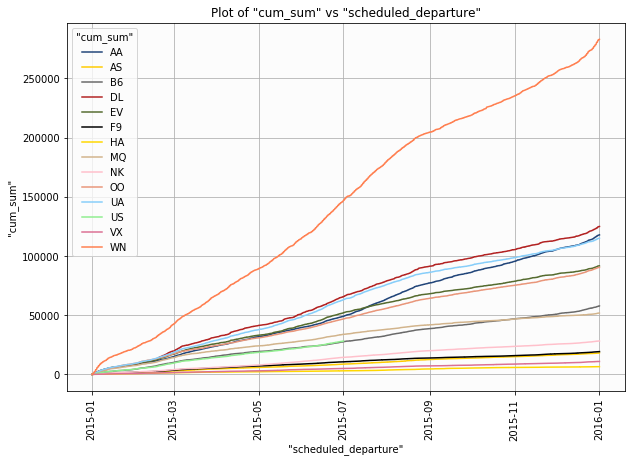

,destination_airport,scheduled_departure,departure_delay,arrival_delay,origin_airport,airline,day,month,company_count_flight_1p_2f,is_dep_delay,cum_sum
0,MIA,2015-01-01 10:00:00,0,0,TPA,AA,1,1,2,0,0
1,DFW,2015-01-01 10:00:00,12,5,SNA,AA,1,1,3,1,1
2,TPA,2015-01-01 10:00:00,-1,-7,MIA,AA,1,1,9,0,1
3,LAX,2015-01-01 10:00:00,-1,8,JFK,AA,1,1,5,0,1
4,PSP,2015-01-01 10:00:00,-2,0,DFW,AA,1,1,32,0,1
,...,...,...,...,...,...,...,...,...,...,...


<object>  Name: flights, Number of rows: 4068736, Number of columns: 11

In [8]:
%matplotlib inline
flights.cumsum("cum_sum", 
               "is_dep_delay", 
               by = ["airline"], 
               order_by = ["scheduled_departure"])["cum_sum"].plot(ts = "scheduled_departure", by = "airline")

<p style="color:red">The flight delays are seasonal and some companies are much more subject to delays than the others. To solve this problem, we need to analyse each company individually and see what is really happening.</p>